In [1]:
#external imports
import sys
import os
import torch
#torch.set_default_dtype(torch.float16)
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import matplotlib
from matplotlib import pyplot as plt
#matplotlib.rcParams['figure.dpi'] = 1200
from mpl_toolkits.axes_grid1 import make_axes_locatable

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_precision = torch.float16
serial_num_gpu = 0

In [3]:
#setup and internal imports
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.insert(0,parent_directory)
from flexcl.flexcl_main import GradientTracker, compute_probability_of_answer
model_name = "mistralai/Mistral-7B-instruct-v0.2"
num_layers = 32
location_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype = model_precision) #LlamaForCausalLM.from_pretrained(model_name)
location_model.cuda(serial_num_gpu)
tok = AutoTokenizer.from_pretrained(model_name, torch_dtype = model_precision)
if tok.pad_token is None:
    tok.add_special_tokens({'pad_token': '[PAD]'})
    location_model.resize_token_embeddings(len(tok))
#torch.set_default_dtype(torch.float32)

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]
model-00001-of-00003.safetensors:   0%|          | 21.0M/4.94G [00:00<00:33, 149MB/s]
model-00001-of-00003.safetensors:   1%|          | 52.4M/4.94G [00:00<00:24, 200MB/s]
model-00001-of-00003.safetensors:   2%|▏         | 83.9M/4.94G [00:00<00:22, 220MB/s]
model-00001-of-00003.safetensors:   2%|▏         | 115M/4.94G [00:00<00:20, 232MB/s] 
model-00001-of-00003.safetensors:   3%|▎         | 147M/4.94G [00:00<00:20, 238MB/s]
model-00001-of-00003.safetensors:   4%|▎         | 178M/4.94G [00:00<00:19, 239MB/s]
model-00001-of-00003.safetensors:   4%|▍         | 210M/4.94G [00:00<00:19, 241MB/s]
model-00001-of-00003.safetensors:   5%|▍         | 241M/4.94G [00:01<00:19, 243MB/s]
model-00001-of-00003.safetensors:   6%|▌         | 273M/4.94G [00:01<00:19, 240MB/s]
model-00001-of-00003.safetensors:   6%|▌         | 304M/4.94G [00:01<00:19, 239MB/s]
model-00001-of-00003.safetensors:   7%|▋         | 336M/4.94G [00:01

In [4]:
class GradientTracker:
    '''
    Attaches itself to a pytorch module and records the gradients throughout its submodules.
    Attributes:
        1. state_gradients_dict: state_gradients_dict[name][i] containing the gradient of submodule name in the i-th
        run (since GradientTracker was attached).
        2. reverse_lookup: reverse_lookup[name] is the module with the appropriate name.
    '''
    #reverse_lookup is only needed because the hook has access to the module but not its name: if the module contained
    #its name as an attribute, there would be no need for this and we could actually implement this class faster, as
    #we'd be able to get the name from the module in O(1) time instead of O(n) time.
    def __init__(self, model):
        # Initializes the tracker, sets the requires_grad property of all parameters to be True and zeros it.
        self.model = model
        for param in model.parameters():
            param.requires_grad = True
        self.reverse_lookup = {}
        for name, module in list(self.model.named_modules(remove_duplicate=False))[1:]:
            self.reverse_lookup[name] = module
        self.reset()
        self.handle = torch.nn.modules.module.register_module_full_backward_hook(self.get_state_gradient)

    def get_key_from_value(self, d, val):
        for key, value in d.items():
            if value is val:  # we want the actual object, not just an identical layer, hence 'is' instead of ==
                return key
        return None

    def get_state_gradient(self, module, grad_input, grad_output):
        name = self.get_key_from_value(self.reverse_lookup, module)
        if name is not None:
            self.state_gradients_dict[name].append(grad_output[0].detach().cpu())

    def reset(self):
        self.state_gradients_dict = {}
        for name, module in list(self.model.named_modules(remove_duplicate=False))[1:]:
            self.state_gradients_dict[name] = []
        self.model.zero_grad()

    def compute_grad_norms(self, component: str = 'mlp', run_num: int = 0, num_input_tokens: int = 0, num_layers: int = 0):
        #Computes the norms for all tokens and layers: ignoring some happens in argmax_grad_norm.
        norms = torch.zeros((num_input_tokens, num_layers))
        for layer, layer_gradients in self.state_gradients_dict.items():
            splitted_layer_name = layer.split('.')
            check=False
            if component in ['mlp']:
                if splitted_layer_name[-1]==component:
                    layer_num = int(splitted_layer_name[-2])
                    check=True
            else:
                raise ValueError("Only component='mlp' is currently supported")
            if check:
                all_tokens_gradients = layer_gradients[run_num][0]
                for token_index, gradient in enumerate(all_tokens_gradients):
                    gradient_norm = torch.linalg.vector_norm(gradient).item()
                    norms[token_index, layer_num] = gradient_norm
        output = torch.zeros((num_input_tokens, num_layers))
        for input_token in range(num_input_tokens):
            for layer in range(num_layers):
                output[input_token, layer] = norms[input_token, layer:layer+1].mean()
        return output

    def remove_handle(self):
        self.handle.remove()

    def argmax_grad_norm(self, start_token_index = 5, end_token_index=-4, start_layer = 0, end_layer = 31, component: str = 'mlp', run_num: int = 0, num_input_tokens: int = None, num_layers: int = 32):
        avg_norm = self.compute_grad_norms(component = component, run_num = run_num, num_input_tokens = num_input_tokens, num_layers = num_layers)[start_token_index:end_token_index+1, start_layer:end_layer+1]
        max_token, max_layer = np.unravel_index(torch.argmax(avg_norm), avg_norm.shape)
        max_token += start_token_index
        max_layer += start_layer
        return max_token, max_layer

def compute_probability_of_answer(tok, probs, answer, llama:bool = True):
    #probs is assumed to be a shape (1, vocab) tensor.
    if answer[0] != " ":
        # Space required for correct tokenization
        answer = " " + answer
    if not llama:
        token = tok(answer)['input_ids'][0]
    else:
        token = tok(answer, add_special_tokens=False)['input_ids'][1] #changing this to 1 from -1, doesn't matter for wrapped, necessary for unwrapped
    prev_prob = probs[0, token]
    return prev_prob

In [5]:
#prompt formatting functions
def wrap(proposition: str, pre: str = 'True or false: ', post: str = '.\nAnswer:') -> str:
    return pre + proposition + post

In [6]:
#proposition_to_trace = "Giorgia Meloni is the Prime Minister of Italy"
#undesired_output = "False"
#desired_output = "True"
#prompt = wrap(proposition_to_trace)

In [7]:
proposition_to_trace = "Turkey is in the European Union"
undesired_output = "False"
desired_output = "True"
prompt = wrap(proposition_to_trace)

In [8]:
def compute_grad_norms_for_single_request(prompt, target_true, target_new, model, tokenizer, loss_type):
    tracker = GradientTracker(model)
    model.zero_grad()
    inp = tokenizer(prompt, return_tensors='pt').to(model.device)
    out = model(**inp)['logits']
    probs = torch.softmax(out[:, -1], dim=1)
    if loss_type in ['both']:
        prev_correct_answer = target_true
        prev_prob = compute_probability_of_answer(tokenizer, probs, prev_correct_answer)
    if loss_type in ['new', 'both']:
        new_correct_answer = target_new
        new_prob = compute_probability_of_answer(tokenizer, probs, new_correct_answer)
    if loss_type == 'new':
        loss = 1-new_prob
    elif loss_type == 'both':
        loss = 1-new_prob+prev_prob
    loss.backward()
    tracker.remove_handle()
    output = tracker.compute_grad_norms(component = 'mlp', num_input_tokens = len(inp['input_ids'][0]), num_layers = num_layers)
    del tracker
    return output

In [9]:
import time
tic = time.perf_counter()
gradients = compute_grad_norms_for_single_request(prompt, undesired_output, desired_output, location_model, tok, "both")
toc = time.perf_counter()
print('time', toc-tic)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1554: UserWarning: For backward hooks to be called, module output should be a Tensor or a tuple of Tensors but received <class 'transformers.modeling_outputs.BaseModelOutputWithPast'>
  warnings.warn("For backward hooks to be called,"
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1554: UserWarning: For backward hooks to be called, module output should be a Tensor or a tuple of Tensors but received <class 'transformers.modeling_outputs.CausalLMOutputWithPast'>
  warnings.warn("For backward hooks to be called,"


time 0.8182296799996038


In [10]:
def plot_results_as_heatmap_for_single_request_with_tokens(gradients, prompt, tokenizer, name, use_bos = True, start = 5, end = -5):
    gradients = gradients[start:end]
    inp = tokenizer(prompt, return_tensors='pt', add_special_tokens=use_bos)
    decoded_tokens = [repr(tokenizer.decode(inp['input_ids'][0][start:end][i])) for i in range(len(inp['input_ids'][0][start:end]))]
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    plt.xticks(range(gradients.shape[1]), range(gradients.shape[1]), fontsize=8)
    plt.yticks(range(gradients.shape[0]), decoded_tokens, fontsize=8)
    im = plt.imshow(gradients, cmap = 'binary')
    plt.title(name)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

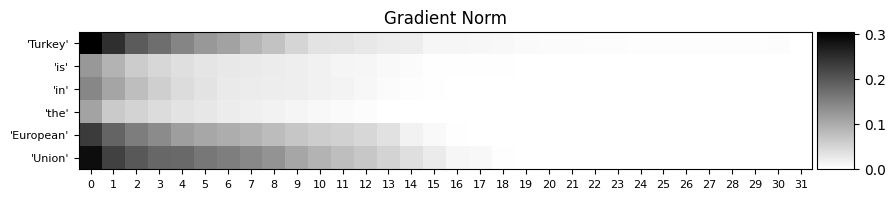

In [11]:
plot_results_as_heatmap_for_single_request_with_tokens(gradients, prompt, tok, 'Gradient Norm', True)